## Huspris

Her har vi data som beskriver boligpriser i Ames, Iowa fra 2006 til 2010. Datasettet inneholder mange variabler som kan brukes til å vurdere boligverdi. Se [her](https://www.kaggle.com/c/house-prices-advanced-regression-techniques/overview) for mer informasjon om data. I denne oppgaven ser vi kun på de numeriske data. 

In [14]:
# imports
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import PolynomialFeatures
from sklearn.dummy import DummyRegressor
from sklearn.linear_model import Lasso
from sklearn.ensemble import RandomForestRegressor
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC
from sklearn.metrics import mean_squared_error

import plotly.express as px
import plotly.graph_objects as go

In [15]:
# les inn husprisdata
df = pd.read_csv('data/huspris.csv')

In [16]:
# del data i mål-, og prediktorvariabler
reduced_df = df.select_dtypes(include=[np.number]).drop('Id', axis=1).dropna()
X = reduced_df.drop('SalePrice', axis=1).values
y = reduced_df['SalePrice'].values

Del data i trenings-, validerigns-, og testdata med størrelser 70%, 15%, 15% av data. 

In [17]:
# dele data i trenings, validerings og testdata
# generer X_train, X_val, X_test, y_train, y_val, y_test

# vi gjør at 70% blir treningsdata

x_train, x_val, y_train, y_val = train_test_split(
    X, y, shuffle=False, test_size=0.3
)

x_val, x_test, y_val, y_test = train_test_split(
    x_val, y_val, shuffle=False, test_size=0.5
)



Tren en Grunnlinjemodell på treningsdata og finn validerings-RMSE. 

In [18]:

baseline = DummyRegressor(strategy="mean")
baseline.fit(x_test, y_test)
baseline

# mse error given the prdicted line, what is distance from the line to actual point, squared and then the mean of all of these
y_predicted = baseline.predict(x_val) #given a new data set x, predict the y values
rmse_baseline = np.round(np.sqrt(mean_squared_error(y_val, y_predicted, squared=False))) #for each predicted y, check distance from known y?
rmse_baseline

298.0

Tren en Lasso regresjonsmodell (sklearn.linear_model.Lasso) med hyperparameter alpha mellom 1 og 500 på treningsdata. Sorter de ulike modellene etter mean kvadrert feil på valideringsdata (sklearn.metrics.mean_squared_error).
Visualiser hvordan mean kvadratisk feil avhenger av alpha. 

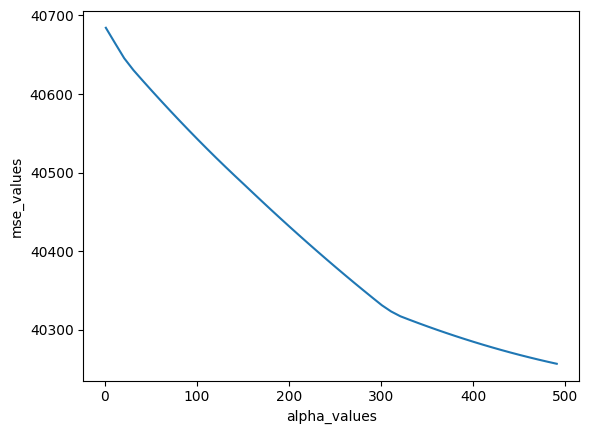

In [19]:
# tren forskjellige modeller

alpha_values = []
mse_values = []

for alpha in np.arange(1, 500, 10):

    clf = Lasso(alpha=alpha)
    clf.fit(x_train, y_train)

    y_predicted = clf.predict(x_val)
    
    # sjekk MSE for valideringsdata
    mse = mean_squared_error(y_val, y_predicted, squared=False)

    alpha_values.append(alpha)
    mse_values.append(mse)

import matplotlib.pyplot as plt

# visualiser validerings-MSE avhengig av alpha

plt.plot(alpha_values,mse_values)
plt.xlabel("alpha_values")
plt.ylabel("mse_values")
plt.show()


## Visualization comment
Here one can see that as alpha increases, MSE decreases. In this case, a higher alpha value is better as the average MSE is better.

Lag alle polynomkombinasjoner av grad 2 av data (sklearn.preprocessing.PolynomialFeatures). 
Tren en Lasso regresjonsmodell (sklearn.linear_model.Lasso) med hyperparameter alpha mellom 500 og 1500 på polynomkombinasjoner av treningsdata.
Sorter de ulike modellene etter mean kvadrert feil på valideringsdata (sklearn.metrics.mean_squared_error).
Visualiser hvordan mean kvadratisk feil avhenger av alpha. 

In [20]:
# lag datasett med polynomielle data

poly = PolynomialFeatures(degree=2)

X_train_pf = poly.fit_transform(x_train)
X_val_pf = poly.transform(x_val)
X_test_pf = poly.transform(x_test)

In [21]:
# tren forskjellige modeller

alpha_values_poly = []
mse_values_poly = []
pf_models = []

for alpha in np.arange(500, 1500, 10):
    clf = Lasso(alpha=alpha)
    clf.fit(X_train_pf, y_train) 
 
    y_predicted = clf.predict(X_val_pf)
    
    #finn mse
    pf_mse = mean_squared_error(y_val, y_predicted, squared=False)

    alpha_values_poly.append(alpha)
    mse_values_poly.append(pf_mse)
    pf_models.append(clf)
    
pf_models


/home/henrik/.local/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 9.667e+10, tolerance: 5.615e+08

/home/henrik/.local/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 9.673e+10, tolerance: 5.615e+08

/home/henrik/.local/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 9.678e+10, tolerance: 5.615e+08

/home/henrik/.local/lib/python3.10/site-packages/

[Lasso(alpha=500),
 Lasso(alpha=510),
 Lasso(alpha=520),
 Lasso(alpha=530),
 Lasso(alpha=540),
 Lasso(alpha=550),
 Lasso(alpha=560),
 Lasso(alpha=570),
 Lasso(alpha=580),
 Lasso(alpha=590),
 Lasso(alpha=600),
 Lasso(alpha=610),
 Lasso(alpha=620),
 Lasso(alpha=630),
 Lasso(alpha=640),
 Lasso(alpha=650),
 Lasso(alpha=660),
 Lasso(alpha=670),
 Lasso(alpha=680),
 Lasso(alpha=690),
 Lasso(alpha=700),
 Lasso(alpha=710),
 Lasso(alpha=720),
 Lasso(alpha=730),
 Lasso(alpha=740),
 Lasso(alpha=750),
 Lasso(alpha=760),
 Lasso(alpha=770),
 Lasso(alpha=780),
 Lasso(alpha=790),
 Lasso(alpha=800),
 Lasso(alpha=810),
 Lasso(alpha=820),
 Lasso(alpha=830),
 Lasso(alpha=840),
 Lasso(alpha=850),
 Lasso(alpha=860),
 Lasso(alpha=870),
 Lasso(alpha=880),
 Lasso(alpha=890),
 Lasso(alpha=900),
 Lasso(alpha=910),
 Lasso(alpha=920),
 Lasso(alpha=930),
 Lasso(alpha=940),
 Lasso(alpha=950),
 Lasso(alpha=960),
 Lasso(alpha=970),
 Lasso(alpha=980),
 Lasso(alpha=990),
 Lasso(alpha=1000),
 Lasso(alpha=1010),
 Lasso(alp

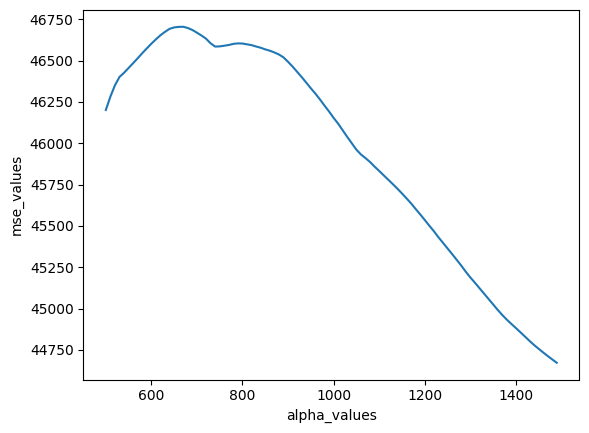

In [22]:
# visualiser validerings-MSE avhengig av alpha
plt.plot(alpha_values_poly,mse_values_poly)
plt.xlabel("alpha_values")
plt.ylabel("mse_values")
plt.show()

Se om du kan finne en bedre modell med en annen metode enn Lasso regresjon (e.g. sklearn.linear_model.ElasticNet, sklearn.ensemble.RandomForestRegressor, sklearn.svm.SVR, sklearn.gaussian_process.GaussianProcessRegressor). Finn gode hyperparametre til metoden du velger ut. 

In [23]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import ElasticNet
from sklearn.svm import SVR
from sklearn.gaussian_process import GaussianProcessRegressor

# tren forskjellige modeller

#her prøver jeg på litt fancy greie ved å kun lage settings ett sted.
#det er kult, men kanskje litt vel overkomplisert

models = [
    {"model_type": Lasso, "settings": {"alpha": 1500}},
    {"model_type": RandomForestRegressor, "settings": {"n_estimators":1000}},
    {"model_type": ElasticNet, "settings": {"alpha": 1500}}, 
    {"model_type": SVR, "settings": {"degree":2}},
    {"model_type": GaussianProcessRegressor, "settings": {"alpha": 1500}},
]

model_strings = []
mse_values_models = []

for mod in models:
    clf = mod["model_type"](**mod["settings"]) #henter ut settings her
    clf.fit(X_train_pf, y_train) 

    y_predicted = clf.predict(X_val_pf)

    #finn mse
    pf_mse = mean_squared_error(y_val, y_predicted, squared=False)

    mse_values_models.append(pf_mse)
    model_strings.append(str(mod["model_type"].__name__))



data_models = pd.DataFrame({
    'model_name': model_strings,
    'mse_values': mse_values_models
})

fig = px.bar(data_models, x='model_name', y='mse_values', 
             title='MSE values for different models', 
             labels={'x':'Model', 'y':'Mean Squared Error'})

fig.show()
print(data_models)


/home/henrik/.local/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.000e+11, tolerance: 5.615e+08

/home/henrik/.local/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.114e+11, tolerance: 5.615e+08



                 model_name     mse_values
0                     Lasso   44652.418247
1     RandomForestRegressor   37297.166779
2                ElasticNet   42081.473045
3                       SVR   90382.427387
4  GaussianProcessRegressor  201908.630852


In [30]:
# sjekk MSE for valideringsdata
mse_val = data_models["mse_values"]
print(mse)

1     37297.166779
2     42081.473045
0     44652.418247
3     90382.427387
4    201908.630852
Name: mse_values, dtype: float64


Velg ut den beste modellen og sjekk hvor godt den generaliserer ved å regne ut mean kvadrert feil og kvadratrooten av mean kvadrert feil på testdata. 

In [25]:
# sjekk generaliseringsevne
best_model = RandomForestRegressor(n_estimators=1000)
best_model.fit(X_train_pf, y_train) 

y_test_predicted = best_model.predict(X_test_pf)

test_mse = mean_squared_error(y_test, y_test_predicted)

test_rmse = mean_squared_error(y_test, y_test_predicted, squared=False)

print('Test MSE:', test_mse)
print('Test RMSE:', test_rmse)

test_mse

Test MSE: 1338851829.9011776
Test RMSE: 36590.32426613869


1338851829.9011776

Gi en oppsummering over hva du har gjort og hva resultatet var. 

Lest inn husprisdata, delt i trening,test og validation

Sett litt på en grunnlinjemodell og dens RMSE

trent lasso modell og sett hvordan mse endrer seg når alpha endrer seg

alpha opp = mse ned

trent noen flere lasso modeller og sett på validerings data mse, når vi endrer alpha

så har vi trent noen flere modeller og sett hvilken som har lavest MSE og det var ```RandomForestRegressor```

Så har vi sjekket ut den modellen, sett på hvor god den er på testdaten, og den va grei.
